# Import library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy, copy
import functools

In [5]:
import cProfile
import pstats
from multiprocessing import Pool

## Random seed

In [6]:
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)

# Function to transform the data

In [7]:
# Function to transfer from dBW to W (power)
def db2pow(db: float) -> float:
    return 10**(db/10)

# Function to transfer from W to dBW (power)
def pow2db(pow: float) -> float:
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x: np.ndarray) -> np.ndarray:
    return x.conj().T

def chanGen(zeta: float, d: float, dim1: int, dim2: int) -> np.ndarray:
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref: float = -30                                    # pathloss (dBW) at reference distance
    pl: float = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y: np.ndarray = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y

## Parameters

In [8]:
sigma = db2pow(-75)                                                                 # noise power
N = 8                                                                               # number of transmit antennas
Nris = 32                                                                           # number of RIS elements
number_of_users = 4                                                                 # number of users
number_of_eavesdroppers = 2                                                         # number of eavesdroppers
zetaAI = 2.2                                                                        # Path loss exponent of the channel between the Alice and the RIS
zetaIB = 2.5                                                                        # Path loss exponent of the channel between the legitimate receivers and the RIS
zetaIE = 2.5                                                                        # Path loss exponent of the channel between the eavesdroppers and the RIS
zetaAB = 3.5                                                                        # Path loss exponent of the channel between the Alice and the legitimate receivers
zetaAE = 3.5                                                                        # Path loss exponent of the channel between the Alice and the eavesdroppers

dAI = 50                                                                            # distance between Alice and the RIS
dv = 2                                                                              # Vertical distance between the Alice and the Eve and Bob
dABh = np.random.uniform(5, 10, size=number_of_users)                               # Horizontal distance between Alice and the legitimate receivers
dAEh = np.random.uniform(50, 150, size=number_of_eavesdroppers)                     # Horizontal distance between Alice and the eavesdroppers
dAB = [np.sqrt(dABh[i]**2 + dv**2) for i in range(number_of_users)]                 # Distance between Alice and the legitimate receivers
dAE = [np.sqrt(dAEh[i]**2 + dv**2) for i in range(number_of_eavesdroppers)]         # Distance between Alice and the eavesdroppers
dIB = [np.sqrt((dABh[i]-dAI)**2 + dv**2) for i in range(number_of_users)]           # Distance between the legitimate receivers and the RIS
dIE = [np.sqrt((dAEh[i]-dAI)**2 + dv**2) for i in range(number_of_eavesdroppers)]   # Distance between the eavesdroppers and the RIS


In [9]:
def normalise_beamforming_vectors(w: np.ndarray) -> np.ndarray:
    """Function to normalise the beamforming vectors

    Args:
        w: the beamforming vectors
    """
    total_norm = 0
    for i in range(number_of_users):
        total_norm += np.linalg.norm(w[i])
    for i in range(number_of_users):
        w[i] = w[i] / total_norm
    return w

def generate_random_beamforming_vector():
  '''
  Generate one random beamforming vector
  '''
  return np.random.uniform(-1, 1, (N, 1)) + 1j * np.random.uniform(-1, 1, (N, 1))

def generate_random_beamforming_vectors():
    # Generate random complex numbers for each element of the beamforming vector
    beamforming_vectors = [generate_random_beamforming_vector() for _ in range (number_of_users)]
    
    # Normalize the vectors
    beamforming_vectors = normalise_beamforming_vectors(beamforming_vectors)
    return beamforming_vectors
    #w: list of beamforming vectors, length = number of users, elements are N x 1

def generate_random_theta():
    theta = np.random.uniform(-np.pi, np.pi, (1, Nris))
    theta = np.exp(1j * theta)
    return theta
    #theta: phase shift of RIS, size 1 x Nris

def generate_random_theta_angles(size: int):
  """
    Generate a random vector of angles from -pi to pi
  """
  return np.random.uniform(-np.pi, np.pi, size=(1, size))

def theta_angles_to_theta_vector(angles: np.ndarray[np.float64]) -> np.ndarray[np.complex128]:
  """
    Convert a vector of angles to a vector of complex numbers on the unit circle
  """
  return np.exp(1j * angles)

def theta_vector_to_theta_angles(theta: np.ndarray[np.complex128]) -> np.ndarray[np.float64]:
  """
    Convert a vector of complex numbers on the unit circle to a vector of angles
  """
  return np.angle(theta)

def generateChannel():
    normFact = 1/np.sqrt(sigma)
    Hai = chanGen(zetaAI, dAI, Nris, N)                                                         # Alice to RIS channel
    hib = [normFact*chanGen(zetaIB, dIB[i], 1, Nris) for i in range(number_of_users)]           # Channel between the RIS and the legitimate receivers
    hie = [normFact*chanGen(zetaIE, dIE[i], 1, Nris) for i in range(number_of_eavesdroppers)]   # Channel between the RIS and the eavesdroppers
    hab = [normFact*chanGen(zetaAB, dAB[i], 1, N) for i in range(number_of_users)]              # Channel between Alice and the legitimate receivers
    hae = [normFact*chanGen(zetaAE, dAE[i], 1, N) for i in range(number_of_eavesdroppers)]      # Channel between Alice and the eavesdroppers
    return Hai, hib, hie, hab, hae

    #Hai: Channel between Alice and RIS: Nris x N  
    #hib: Channel between RIS and users: List of length number_of_users, elements are 1 x Nris
    #hab: Channel between Alice and users: List of length number_of_users, elements are 1 x N
    #hie: Channel between RIS and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x Nris
    #hae: Channel between Alice and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x N

In [10]:
# Reseed
# np.random.seed(RANDOM_SEED)

# Channel generation
Hai, hib, hie, hab, hae = generateChannel()

# Generate random theta and w
theta_init = generate_random_theta()
w_init = generate_random_beamforming_vectors()

# Objective Function

In [11]:
def secrecy_rate_objective_function(theta, w) -> float:
    secrecy_rate: float = 0
    for k in range(number_of_users):
        R_bk = []
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        for m in range(number_of_eavesdroppers):
            # Eavesdropper i
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            C_em = np.log2(1 + gamma_em)
            R_bk.append(C_bk - C_em)
        
        secrecy_rate += max(min(R_bk),0)

    # Return the only element in the matrix as it is currently a 1x1 np array
    return secrecy_rate[0, 0]

In [12]:
# print(theta_init)
print("distance between Alice and the receivers: ", dAB)
print("distance between Alice and the eavesdroppers: ", dAE)
print("Secrecy Rate:", secrecy_rate_objective_function(theta_init, w_init))

distance between Alice and the receivers:  [np.float64(8.597260577730964), np.float64(7.704507320858385), np.float64(9.344025672091696), np.float64(5.531459234567628)]
distance between Alice and the eavesdroppers:  [np.float64(130.82028537878898), np.float64(106.58050877047856)]
Secrecy Rate: 1.0304382881643281


# Method

## Gradient Descent for Maximization (GD)

In [13]:
def compute_gradient_w(theta, w):
    grad_w = []
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    

    #Precalculation 
    for k in range (number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])


    #Calculating grad for i-th beamforming vector
    for i in range(number_of_users):
        grad = np.zeros((N, 1))
        #print("grad_shape =", grad.shape)
        for k in range (number_of_users):
            if (counted[k] == False):
                continue
            if (k == i):
                num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[k])
                den_grad_C_bk_to_w_k = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k

                num_grad_C_e_max_to_w_k = 2 * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[k])
                den_grad_C_e_max_to_w_k = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_e_max_to_w_k = num_grad_C_e_max_to_w_k / den_grad_C_e_max_to_w_k
                
                #print("num_grad_C_e_max_to_w_k", num_grad_C_e_max_to_w_k.shape)
                #print("den_grad_C_e_max_to_w_k", den_grad_C_e_max_to_w_k.shape)
                grad = grad - (grad_C_bk_to_w_k - grad_C_e_max_to_w_k)
            else:
                num_grad_C_bk_to_w_i = -2 * abs(Z_b[k] @ w[k]) * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[i])
                den_grad_C_bk_to_w_i = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_bk_to_w_i = num_grad_C_bk_to_w_i / den_grad_C_bk_to_w_i

                num_grad_C_e_max_to_w_i = -2 * abs(Z_e_max[k] @ w[k]) * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[i])
                den_grad_C_e_max_to_w_i = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_e_max_to_w_i = num_grad_C_e_max_to_w_i / den_grad_C_e_max_to_w_i

                grad = grad - (grad_C_bk_to_w_i - grad_C_e_max_to_w_i)
            
        grad_w.append(grad)
    return grad_w

def compute_gradient_theta_central(theta, w, epsilon=1e-3):
    perturbation = epsilon + epsilon * 1j
    grad_theta = []
    for i in range(Nris):
        theta_plus = copy(theta)
        theta_plus[0, i] += perturbation
        theta_minus = copy(theta)
        theta_minus[0, i] -= perturbation
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - secrecy_rate_objective_function(theta_minus, w)) / (2*epsilon)
        grad_theta.append(grad_theta_i)
            
    return np.array(grad_theta)

def compute_gradient_theta(theta, w, original_secrecy_rate=None, epsilon=1e-3):
    """
    Faster implementation of the gradient calculation

    Improvements:
    - Use forward difference instead of central difference
    """
    perturbation = epsilon + epsilon * 1j
    grad_theta = []
    for i in range(Nris):
        theta_plus = copy(theta)
        theta_plus[0, i] += perturbation
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - original_secrecy_rate) / epsilon
        grad_theta.append(grad_theta_i)

    return np.array(grad_theta)


def gradient_descent_update(w, theta, learning_rate, original_secrecy_rate=None):
    grad_w = compute_gradient_w(theta, w)
    grad_theta = compute_gradient_theta(theta, w, original_secrecy_rate)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    total_norm = 0
    for i in range (number_of_users):
        total_norm += np.linalg.norm(w_new[i])
    for i in range (number_of_users):
        w_new[i] = w_new[i] / total_norm
        
    theta_new = theta - learning_rate * grad_theta
    theta_new = np.exp(1j * np.angle(theta_new))

    return w_new, theta_new

In [14]:
# Reseed first
np.random.seed(RANDOM_SEED)

# Gradient Descent Algorithm
num_cycles = 500
learning_rate = 0.01
theta_GD = generate_random_theta()
w_GD = generate_random_beamforming_vectors()
print("Initial Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
current_secrecy_rate = secrecy_rate_objective_function(theta_init, w_init)

GD_results = []
GD_results.append(current_secrecy_rate)

for i in range(num_cycles):
    w_new, theta_new = gradient_descent_update(w_GD, theta_GD, learning_rate, original_secrecy_rate=current_secrecy_rate)
    new_secrecy_rate = secrecy_rate_objective_function(theta_new, w_new)
    # print(new_secrecy_rate)
    if (new_secrecy_rate - current_secrecy_rate) < 1e-9:
        print("Converged")
        break
    w_GD = w_new
    theta_GD = theta_new
    GD_results.append(new_secrecy_rate)
    current_secrecy_rate = new_secrecy_rate

print(GD_results)
print("Final Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))

Initial Secrecy Rate GD: 1.2080238931977207
Converged
[np.float64(1.0304382881643281), np.float64(6.118621974604992), np.float64(8.696606202668494), np.float64(9.870564541150003), np.float64(10.61565521623102), np.float64(11.15330742326103), np.float64(11.546885679836965), np.float64(11.837522217687441), np.float64(12.05529429707602), np.float64(12.220996986919342), np.float64(12.348792792227963), np.float64(12.448538028550828), np.float64(12.527439073336147), np.float64(12.590554409322387), np.float64(12.641663260789842), np.float64(12.683589694060256), np.float64(12.71845871611104), np.float64(12.747875257186632), np.float64(12.773054442246746), np.float64(12.794917614361935), np.float64(12.814164053465657), np.float64(12.831324987560528), np.float64(12.846804468800919), np.float64(12.86091037652741), np.float64(12.87387793929189), np.float64(12.885887565316043), np.float64(12.89707833758916), np.float64(12.907558208728522), np.float64(12.917411687801103), np.float64(12.9267056253235

## Particle Swarm Optimization (PSO)

In [15]:
class PSOParticle:
  def __init__(self) -> None:
    self.theta = generate_random_theta_angles(Nris)
    self.w = generate_random_beamforming_vectors()
    self.best_theta = deepcopy(self.theta)
    self.best_w = deepcopy(self.w)
    self.best_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.best_theta), self.best_w)
    self.velocity_theta = np.zeros((1, Nris))
    self.velocity_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  def update_velocity(self, inertia, c1, c2, global_best_theta, global_best_w):
    r1 = np.random.rand()
    r2 = np.random.rand()
    self.velocity_theta = inertia * self.velocity_theta + c1 * r1 * (self.best_theta - self.theta) + c2 * r2 * (global_best_theta - self.theta)
    self.velocity_w = [inertia * self.velocity_w[i] + c1 * r1 * (self.best_w[i] - self.w[i]) + c2 * r2 * (global_best_w[i] - self.w[i]) for i in range(number_of_users)]

  def update_position(self):
    self.theta = self.theta + self.velocity_theta
    self.w = [self.w[i] + self.velocity_w[i] for i in range(number_of_users)]
    total_norm = 0
    for i in range (number_of_users):
        total_norm += np.linalg.norm(self.w[i])
    for i in range(number_of_users):
        self.w[i] = self.w[i] / total_norm


  def update_best(self):
    current_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)
    if current_secrecy_rate > self.best_secrecy_rate:
      self.best_secrecy_rate = current_secrecy_rate
      self.best_theta = deepcopy(self.theta)
      self.best_w = deepcopy(self.w)

In [16]:
def dynamic_inertia(i: int, max_iter: int, inertia_max: float, inertia_min: float) -> float:
  E_t = float((max_iter - i - 1)/max_iter)
  inertia = inertia_min + (inertia_max - inertia_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)
  return inertia

In [17]:
def PSO_optimize_w_theta(max_iter: int, num_particles: int, w_min: float, w_max: float, c1: float, c2: float):
  particles = [PSOParticle() for _ in range(num_particles)]
  global_best_secrecy_rate = -np.inf
  global_best_theta = np.zeros((1, Nris))
  global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  results_secrecy_rate = []

  for particle in particles:
    if particle.best_secrecy_rate > global_best_secrecy_rate:
      global_best_secrecy_rate = particle.best_secrecy_rate
      global_best_theta = deepcopy(particle.best_theta)
      global_best_w = deepcopy(particle.best_w)

  results_secrecy_rate.append(global_best_secrecy_rate)

  for iteration in range(max_iter):
    inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

    for particle in particles:
      particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
      particle.update_position()
      particle.update_best()

      if particle.best_secrecy_rate > global_best_secrecy_rate:
        global_best_secrecy_rate = particle.best_secrecy_rate
        global_best_theta = deepcopy(particle.best_theta)
        global_best_w = deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)

  return results_secrecy_rate

In [18]:
# Reseed
np.random.seed(RANDOM_SEED)

# PSO Algorithm
max_iter = 500
num_particles = 100
w_min = 0.5
w_max = 0.9
c1 = 1.5
c2 = 1.5

PSO_results = PSO_optimize_w_theta(max_iter, num_particles, w_min, w_max, c1, c2)
print("Initial Secrecy Rate PSO:", PSO_results[0])
print(PSO_results)
print("Final Secrecy Rate PSO:", PSO_results[-1])

Initial Secrecy Rate PSO: 3.782669340293348
[np.float64(3.782669340293348), np.float64(7.27015869702259), np.float64(7.458103555294634), np.float64(7.458103555294634), np.float64(7.561774537274905), np.float64(7.824292146645841), np.float64(7.935926466190117), np.float64(8.215962066273109), np.float64(8.267887698862815), np.float64(8.406958649099684), np.float64(8.4269065902722), np.float64(8.460557831699361), np.float64(8.471013569453259), np.float64(8.50658819637212), np.float64(8.548326629987855), np.float64(8.589094950964), np.float64(8.639798146361018), np.float64(8.672306724700572), np.float64(8.72814308249653), np.float64(8.964862038283663), np.float64(9.058763159365984), np.float64(9.068630107746985), np.float64(9.093669292425396), np.float64(9.147765930218814), np.float64(9.153988586948213), np.float64(9.153988586948213), np.float64(9.158739096211445), np.float64(9.172630526805452), np.float64(9.182309966850095), np.float64(9.188334850070417), np.float64(9.195817247124642), np

## Genetic Algorithm (GA)

In [19]:
class GAIndividual:
  def __init__(self, theta: np.ndarray[np.float64] = None, w: np.ndarray[np.complex128] = None) -> None:
    if theta is None:
      self.theta = generate_random_theta_angles(Nris)
    else:
      self.theta = theta

    if w is None:
      self.w = generate_random_beamforming_vectors()
    else:
      self.w = w

    self.update_fitness()

  def update_fitness(self):
    self.fitness = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)


class GAPopulation:
  def __init__(self, population_size: int, crossover_rate: float = 0.85, mutation_rate: float = 0.3) -> None:
    self.population_size = population_size
    self.individuals = [GAIndividual() for _ in range(population_size)]
    self.crossover_rate = crossover_rate
    self.mutation_rate = mutation_rate

  def sort_population(self):
    self.individuals.sort(key=lambda x: x.fitness, reverse=True)

  def filter_population(self):
    self.sort_population()
    self.individuals = self.individuals[:self.population_size]

  def add_individual(self, individual: GAIndividual):
    self.individuals.append(individual)

  def select_parents(self) -> tuple[GAIndividual, GAIndividual]:
    parents = np.random.choice(self.individuals, 2, replace=False)
    return parents[0], parents[1]
  
  def crossover(self, parent1: GAIndividual, parent2: GAIndividual) -> GAIndividual:
    theta1, w1 = parent1.theta, parent1.w
    theta2, w2 = parent2.theta, parent2.w
    theta_child = (theta1 + theta2) / 2
    w_child = [(w1[i] + w2[i]) / 2 for i in range(number_of_users)]
    return GAIndividual(theta_child, w_child)
  
  def mutate(self, individual: GAIndividual) -> GAIndividual:
    if np.random.rand() < self.mutation_rate:
      mutation_index = np.random.randint(0, Nris)
      individual.theta[0, mutation_index] = np.random.uniform(-np.pi, np.pi)
      mutation_index = np.random.randint(len(individual.w))
      individual.w[mutation_index] = generate_random_beamforming_vector()
      individual.update_fitness()

    return individual
  
def GA_optimize_w_theta(population_size: int, max_iter: int, crossover_rate: float = 0.85, mutation_rate: float = 0.85):
  population = GAPopulation(population_size, crossover_rate, mutation_rate)
  population.sort_population()
  results_secrecy_rate = []
  results_secrecy_rate.append(population.individuals[0].fitness)

  for _ in range(max_iter):
    # Crossover
    for _ in range(population_size):
      if np.random.rand() < population.crossover_rate:
        parent1, parent2 = population.select_parents()
        child = population.crossover(parent1, parent2)
        population.mutate(child)
    #Mutate 
        population.add_individual(child)

    # Filter
    population.filter_population()

    results_secrecy_rate.append(population.individuals[0].fitness)

  return results_secrecy_rate

In [20]:
population_size = 100
num_generations = 500
crossover_rate = 0.85
mutation_rate = 0.3

# Reseed
np.random.seed(RANDOM_SEED)

# GA Algorithm
GA_results = GA_optimize_w_theta(population_size, num_generations, crossover_rate, mutation_rate)
print("Initial Secrecy Rate GA:", GA_results[0])
print(GA_results)
print("Final Secrecy Rate GA:", GA_results[-1])

Initial Secrecy Rate GA: 3.782669340293348
[np.float64(3.782669340293348), np.float64(7.4761705083601795), np.float64(8.056008564806197), np.float64(8.420102737788906), np.float64(8.420102737788906), np.float64(8.420102737788906), np.float64(8.420102737788906), np.float64(8.420102737788906), np.float64(8.420102737788906), np.float64(10.072153035906933), np.float64(10.072153035906933), np.float64(10.072153035906933), np.float64(10.38098565322367), np.float64(10.38098565322367), np.float64(10.38098565322367), np.float64(10.38098565322367), np.float64(11.384256543344591), np.float64(11.384256543344591), np.float64(11.422239643595429), np.float64(11.422239643595429), np.float64(11.772397854515297), np.float64(11.772397854515297), np.float64(11.772397854515297), np.float64(11.772397854515297), np.float64(13.211380909034006), np.float64(13.211380909034006), np.float64(13.211380909034006), np.float64(13.211380909034006), np.float64(13.211380909034006), np.float64(13.211380909034006), np.float

## Combination of PSO and GD

In [21]:
def PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, learning_rate, w_max, w_min, c1, c2):
    particles = [PSOParticle() for _ in range(number_of_particles)]
    global_best_secrecy_rate = -np.inf
    global_best_theta = np.zeros((1, Nris))
    global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

    results_secrecy_rate = []

    for particle in particles:
        if particle.best_secrecy_rate > global_best_secrecy_rate:
            global_best_secrecy_rate = particle.best_secrecy_rate
            global_best_theta = deepcopy(particle.best_theta)
            global_best_w = deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)
    
    for iteration in range(max_pso_iter):
        inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

        """
            Gradient descent for every particles
        """
        for particle in particles:
            for _ in range (max_gd_iter):
                new_w, new_theta = gradient_descent_update(particle.w, theta_angles_to_theta_vector(particle.theta), learning_rate, original_secrecy_rate=particle.best_secrecy_rate)
                particle.w = new_w
                particle.theta = theta_vector_to_theta_angles(new_theta)
                particle.update_best()

            if particle.best_secrecy_rate > global_best_secrecy_rate:
                global_best_secrecy_rate = particle.best_secrecy_rate
                global_best_theta = deepcopy(particle.best_theta)
                global_best_w = deepcopy(particle.best_w)

        """
            Update particles by velocity
        """
        
        for particle in particles:
            particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
            particle.update_position()
            particle.update_best()

            if particle.best_secrecy_rate > global_best_secrecy_rate:
                global_best_secrecy_rate = particle.best_secrecy_rate
                global_best_theta = deepcopy(particle.best_theta)
                global_best_w = deepcopy(particle.best_w)

        results_secrecy_rate.append(global_best_secrecy_rate)

    return results_secrecy_rate

In [22]:
# Reseed
np.random.seed(RANDOM_SEED)

max_pso_iter = 50
max_gd_iter = 10
number_of_particles = 100
w_max = 0.9
w_min = 0.5
c1 = 1.5
c2 = 1.5

PSO_GD_results = PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, learning_rate, w_max, w_min, c1, c2)
print("Initial Secrecy Rate PSO-GD:", PSO_GD_results[0])
print("Final Secrecy Rate PSO-GD:", PSO_GD_results[-1])

Initial Secrecy Rate PSO-GD: 3.782669340293348
Final Secrecy Rate PSO-GD: 13.222333850552172


# Plot diagram

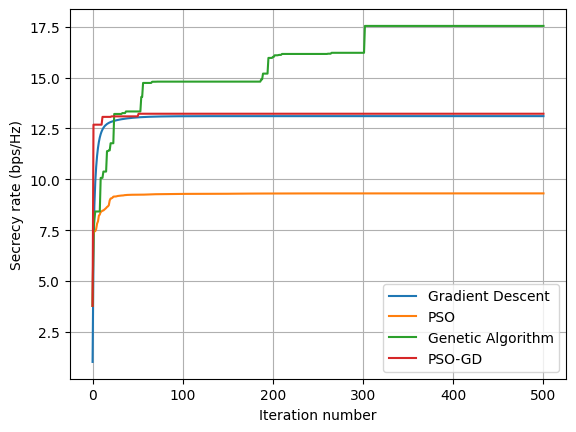

In [35]:
# iterations = range(0, num_cycles+10, 10)

iterations = range(0, max_iter+1)

# Extend the results to the same length
GD_results_draw = GD_results + [GD_results[-1]] * (max_iter + 1 - len(GD_results))
PSO_results_draw = PSO_results + [PSO_results[-1]] * (max_iter + 1 - len(PSO_results))
GA_results_draw = GA_results + [GA_results[-1]] * (max_iter + 1 - len(GA_results))

PSO_GD_results_draw = [PSO_GD_results[0]]
for i in range(1, len(PSO_GD_results)):
    PSO_GD_results_draw.extend([PSO_GD_results[i]] * (max_iter // (len(PSO_GD_results) - 1)))

plt.plot(iterations, GD_results_draw, label='Gradient Descent')
plt.plot(iterations, PSO_results_draw, label='PSO')
plt.plot(iterations, GA_results_draw, label='Genetic Algorithm')
plt.plot(iterations, PSO_GD_results_draw, label='PSO-GD')

plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.grid(True)
plt.legend()
plt.show()


In [33]:
# Best results of each methods
print("Best Secrecy Rate GD:", max(GD_results))
print("Best Secrecy Rate PSO:", max(PSO_results))
print("Best Secrecy Rate GA:", max(GA_results))
print("Best Secrecy Rate PSO-GD:", max(PSO_GD_results))

Best Secrecy Rate GD: 13.10386140080065
Best Secrecy Rate PSO: 9.309463922566332
Best Secrecy Rate GA: 17.535886709078024
Best Secrecy Rate PSO-GD: 13.222333850552172
